In [100]:
                        
import joblib
import math
import json
import pandas as pd
import numpy as np

from scipy.integrate import simpson as simps
from scipy.signal import find_peaks

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
# Load the dataset
df = pd.read_csv('vegemite.csv')

df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Shuffle the dataset
df_sampled = pd.concat([
    df_shuffled[df_shuffled['Class'] == 0].sample(n=333, random_state=42),
    df_shuffled[df_shuffled['Class'] == 1].sample(n=333, random_state=42),
    df_shuffled[df_shuffled['Class'] == 2].sample(n=334, random_state=42)
])
# Display the first few rows of the shuffled dataset
df_shuffled.head()

,FFTE Feed tank level SP,FFTE Production solids SP,FFTE Steam pressure SP,TFE Out flow SP,TFE Production solids SP,TFE Vacuum pressure SP,TFE Steam pressure SP,TFE Steam temperature SP,FFTE Feed flow SP,FFTE Out steam temp SP,...,TFE Out flow PV,TFE Product out temperature,TFE Production solids PV,TFE Production solids density,TFE Steam pressure PV,TFE Steam temperature,TFE Tank level,TFE Temperature,TFE Vacuum pressure PV,Class
0,50.0,43.0,122.0,2609.30,69.0,-53.42,120.0,80.0,10300.0,50.12,...,943.58,0.0,54.33,1.26,120.23,67.88,82.52,67.0,-79.13,2
1,50.0,41.5,100.0,2038.55,65.0,-80.00,120.0,80.0,9400.0,50.00,...,1840.47,0.0,61.01,1.22,119.91,69.76,41.13,78.0,-72.11,0
2,50.0,40.5,115.0,2119.48,39.5,-46.55,120.0,80.0,9230.0,50.00,...,2756.81,0.0,50.27,1.19,0.00,51.14,83.38,62.0,-72.82,0
3,50.0,40.5,125.0,1982.74,63.0,-76.34,120.0,80.0,9400.0,50.00,...,1763.94,0.0,54.19,1.22,119.91,63.41,86.41,70.0,-77.74,0
4,50.0,43.0,90.0,2897.65,5.0,-45.00,100.0,80.0,10130.0,49.28,...,988.33,0.0,74.35,1.27,119.91,82.29,79.20,82.0,-70.36,1


Randomly Take Out 1000 Data Points with Near Equal Distribution


In [102]:
# Inspect the structure and types of the dataset
dataset_info = df.info()

# Display summary statistics of the dataset
summary_statistics = df.describe()

# Check for unique values in each column
unique_values = df.nunique()

dataset_info, summary_statistics, unique_values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15237 entries, 0 to 15236
Data columns (total 47 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   FFTE Feed tank level SP        15237 non-null  float64
 1   FFTE Production solids SP      15237 non-null  float64
 2   FFTE Steam pressure SP         15237 non-null  float64
 3   TFE Out flow SP                15237 non-null  float64
 4   TFE Production solids SP       15237 non-null  float64
 5   TFE Vacuum pressure SP         15237 non-null  float64
 6   TFE Steam pressure SP          15237 non-null  float64
 7   TFE Steam temperature SP       15237 non-null  float64
 8   FFTE Feed flow SP              15237 non-null  float64
 9   FFTE Out steam temp SP         15237 non-null  float64
 10  Extract tank Level             15237 non-null  float64
 11  Extract tank Out flow PV       15237 non-null  float64
 12  FFTE Discharge density         15237 non-null 

(None,
        FFTE Feed tank level SP  FFTE Production solids SP  \
 count             15237.000000               15237.000000   
 mean                 46.660760                  41.834045   
 std                   8.504626                   1.142426   
 min                  25.000000                  39.000000   
 25%                  50.000000                  41.110000   
 50%                  50.000000                  42.000000   
 75%                  50.000000                  43.000000   
 max                  50.000000                  43.000000   
 
        FFTE Steam pressure SP  TFE Out flow SP  TFE Production solids SP  \
 count            15237.000000     15237.000000              15237.000000   
 mean               118.767011      2434.316757                 62.635479   
 std                 17.303951       395.339898                 15.118098   
 min                 60.000000      1687.180000                  0.000000   
 25%                106.000000      2066.670000 

In [103]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

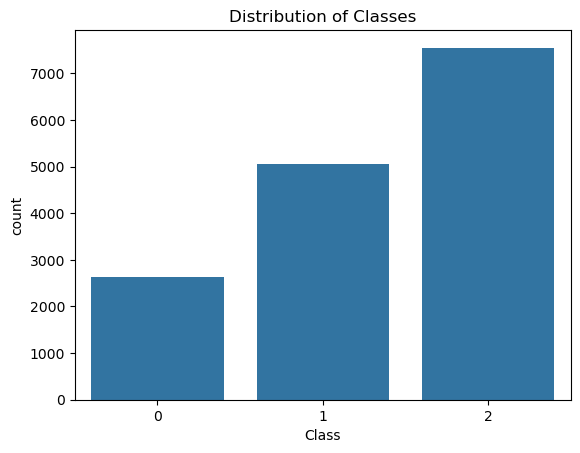

In [104]:
# Plot the distribution of the 'Class' variable
sns.countplot(x='Class', data=df)
plt.title('Distribution of Classes')
plt.show()

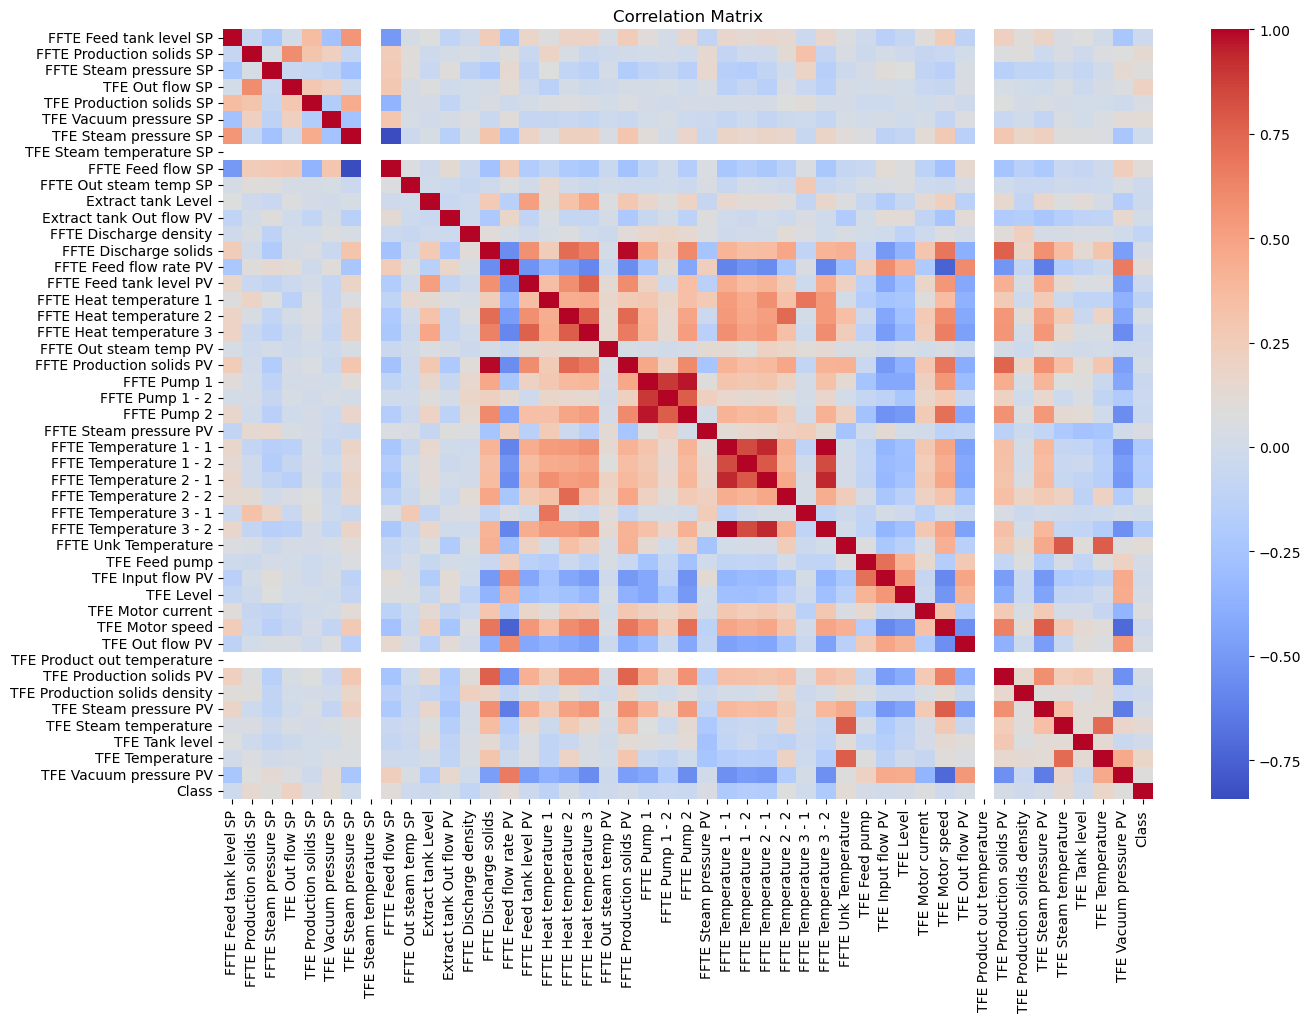

In [105]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

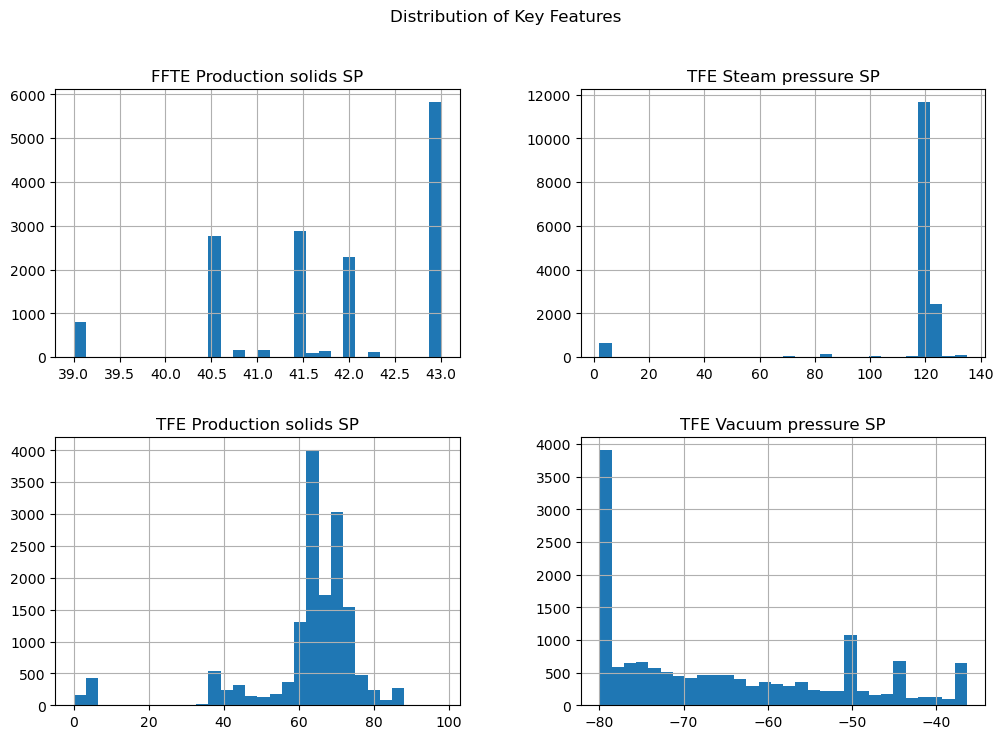

In [106]:
# Select some key features for visualization
key_features = ['FFTE Production solids SP', 'TFE Steam pressure SP', 'TFE Production solids SP', 'TFE Vacuum pressure SP']

# Plot histograms for key features
df[key_features].hist(figsize=(12, 8), bins=30, layout=(2, 2))
plt.suptitle('Distribution of Key Features')
plt.show()

In [107]:
# Remove constant features
df = df.loc[:, df.nunique() > 1]

# Select features with a low correlation to others or use dimensionality reduction methods
selected_features = df.columns[df.columns.str.endswith('SP')]  # Using only SP features for this model

selected_features.tolist()

['FFTE Feed tank level SP',
 'FFTE Production solids SP',
 'FFTE Steam pressure SP',
 'TFE Out flow SP',
 'TFE Production solids SP',
 'TFE Vacuum pressure SP',
 'TFE Steam pressure SP',
 'FFTE Feed flow SP',
 'FFTE Out steam temp SP']

In [108]:
# Define the threshold for few unique values
threshold = 10

# Identify columns with fewer unique values than the threshold
few_unique_values_columns = df.nunique()[df.nunique() < threshold]

print(few_unique_values_columns)


FFTE Feed tank level SP    3
FFTE Pump 1                5
FFTE Pump 1 - 2            4
FFTE Pump 2                5
TFE Motor speed            3
Class                      3
dtype: int64


In [109]:

# Convert these columns to categorical type
for col in few_unique_values_columns.index:
    df[col] = df[col].astype('category')

# Verify conversion
print(df.dtypes)

FFTE Feed tank level SP          category
FFTE Production solids SP         float64
FFTE Steam pressure SP            float64
TFE Out flow SP                   float64
TFE Production solids SP          float64
TFE Vacuum pressure SP            float64
TFE Steam pressure SP             float64
FFTE Feed flow SP                 float64
FFTE Out steam temp SP            float64
Extract tank Level                float64
Extract tank Out flow PV          float64
FFTE Discharge density            float64
FFTE Discharge solids             float64
FFTE Feed flow rate PV            float64
FFTE Feed tank level PV           float64
FFTE Heat temperature 1           float64
FFTE Heat temperature 2           float64
FFTE Heat temperature 3           float64
FFTE Out steam temp PV            float64
FFTE Production solids PV         float64
FFTE Pump 1                      category
FFTE Pump 1 - 2                  category
FFTE Pump 2                      category
FFTE Steam pressure PV            

In [110]:
# Split the dataset into training and testing before oversampling
X_train, X_test, y_train, y_test = train_test_split(df[selected_features], df['Class'], test_size=1000, stratify=df['Class'], random_state=42)


In [111]:

# Define the oversampler (SMOTE)
oversampler = SMOTE(sampling_strategy='auto', random_state=42)

# Apply oversampling to the training data only
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Split the resampled data into training and testing
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, stratify=y_train_resampled, random_state=42)

# To view the number of features in the final dataset
num_features = X_train_resampled.shape[1]  # After oversampling
print(f'The final training dataset includes {num_features} features.')

The final training dataset includes 9 features.


In [112]:
print(f'DF Size: {df.shape}')

DF Size: (15237, 45)


In [113]:
print(f'Train Size: {X_train.shape[0]}')
print(f'Train Resampled Size: {X_train_resampled.shape[0]}')

Train Size: 14237
Train Resampled Size: 16927


In [114]:
# Define pipelines to handle missing values for models that need it
dt_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('model', DecisionTreeClassifier())
])

rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('model', RandomForestClassifier())
])

gb_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('model', GradientBoostingClassifier())
])

svm_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('model', SVC())
])

knn_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('model', KNeighborsClassifier())
])

# Models to train (using pipelines for all models)
models = {
    'DecisionTree': dt_pipeline,
    'RandomForest': rf_pipeline,
    'GradientBoosting': gb_pipeline,
    'SVM': svm_pipeline,
    'KNN': knn_pipeline
}

# Train and evaluate each model using the resampled training data and the untouched test data
results = {}
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)  # Train on the resampled training set
    predictions = model.predict(X_val)  # Evaluate on the original test set
    results[name] = {
        'report': classification_report(y_val, predictions, output_dict=True),
        'conf_matrix': confusion_matrix(y_val, predictions)
    }

# Display results
results


{'DecisionTree': {'report': {'0': {'precision': 0.9492600422832981,
    'recall': 0.9553191489361702,
    'f1-score': 0.9522799575821845,
    'support': 1410},
   '1': {'precision': 0.9286733238231099,
    'recall': 0.9227498228206945,
    'f1-score': 0.9257020974049058,
    'support': 1411},
   '2': {'precision': 0.9298369950389794,
    'recall': 0.9298369950389794,
    'f1-score': 0.9298369950389794,
    'support': 1411},
   'accuracy': 0.9359640831758034,
   'macro avg': {'precision': 0.9359234537151292,
    'recall': 0.9359686555986148,
    'f1-score': 0.9359396833420233,
    'support': 4232},
   'weighted avg': {'precision': 0.9359203023473199,
    'recall': 0.9359640831758034,
    'f1-score': 0.9359358222186206,
    'support': 4232}},
  'conf_matrix': array([[1347,   30,   33],
         [  43, 1302,   66],
         [  29,   70, 1312]], dtype=int64)},
 'RandomForest': {'report': {'0': {'precision': 0.9605355884425651,
    'recall': 0.9666666666666667,
    'f1-score': 0.96359137504

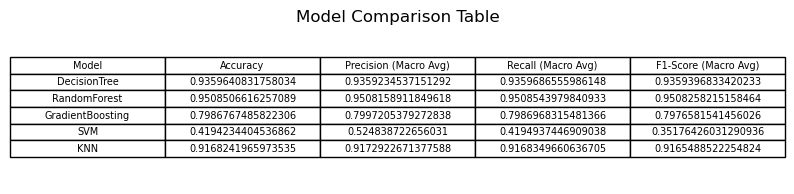

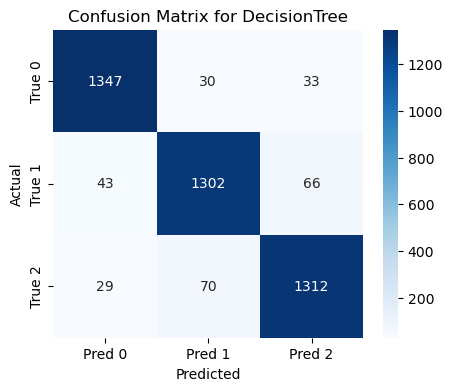

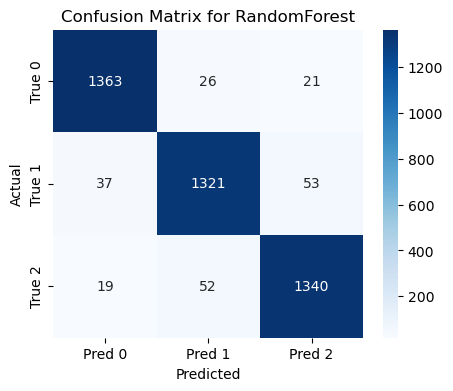

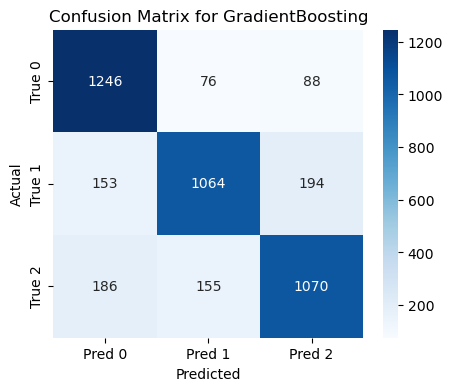

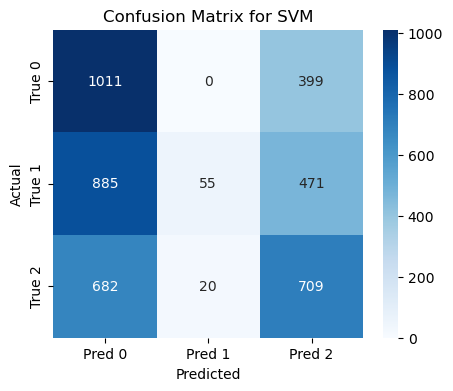

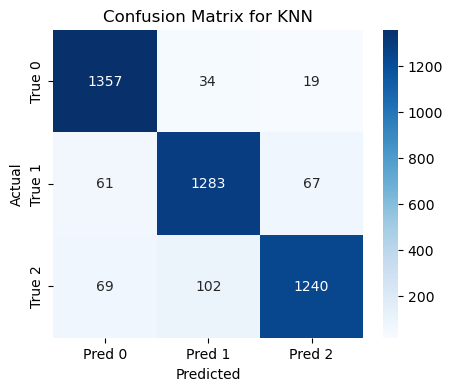

The best model is RandomForest with an accuracy of 0.951


In [115]:
# Initialize lists to store comparison data
model_names = []
accuracies = []
precisions = []
recalls = []
f1_scores = []
confusion_matrices = []

# Initialize variables to store the best model information
best_model_name = None
best_model_accuracy = 0

# Extract data from results dictionary
for model_name, model_results in results.items():
    model_names.append(model_name)
    accuracies.append(model_results['report']['accuracy'])
    precisions.append(model_results['report']['macro avg']['precision'])
    recalls.append(model_results['report']['macro avg']['recall'])
    f1_scores.append(model_results['report']['macro avg']['f1-score'])
    confusion_matrices.append(model_results['conf_matrix'])
    
    model_accuracy = model_results['report']['accuracy']
    if model_accuracy > best_model_accuracy:
        best_model_name = model_name
        best_model_accuracy = model_accuracy

# Create a DataFrame for the comparison table
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision (Macro Avg)': precisions,
    'Recall (Macro Avg)': recalls,
    'F1-Score (Macro Avg)': f1_scores
})

# Function to plot table
def plot_table(df, title):
    fig, ax = plt.subplots(figsize=(10, 2))  # set size frame
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
    plt.title(title)
    plt.show()

# Display the comparison table as an image
plot_table(comparison_df, "Model Comparison Table")

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Pred 0', 'Pred 1', 'Pred 2'], yticklabels=['True 0', 'True 1', 'True 2'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Display the confusion matrices as images
for model_name, conf_matrix in zip(model_names, confusion_matrices):
    plot_confusion_matrix(conf_matrix, model_name)

print(f"The best model is {best_model_name} with an accuracy of {best_model_accuracy:.3f}")

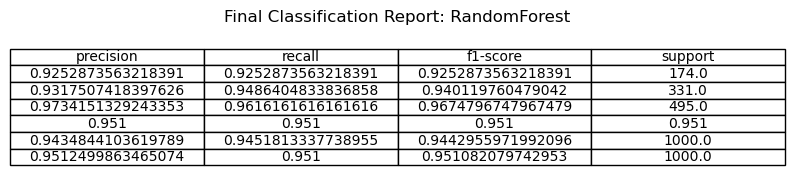

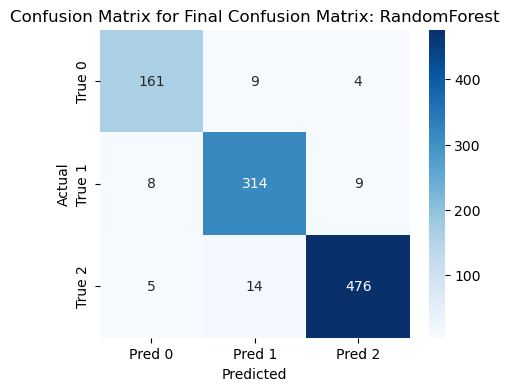

In [116]:
# Test the model on unseen data points (already done in the previous steps)
final_predictions = models['RandomForest'].predict(X_test)

# Evaluate the performance on the unseen data points
final_report = classification_report(y_test, final_predictions, output_dict=True)
final_conf_matrix = confusion_matrix(y_test, final_predictions)

# Convert classification report to DataFrame for better visualization
final_report_df = pd.DataFrame(final_report).transpose()

# Plot the final classification report as a table
plot_table(final_report_df, "Final Classification Report: RandomForest")

# Plot the final confusion matrix
plot_confusion_matrix(final_conf_matrix, "Final Confusion Matrix: RandomForest")

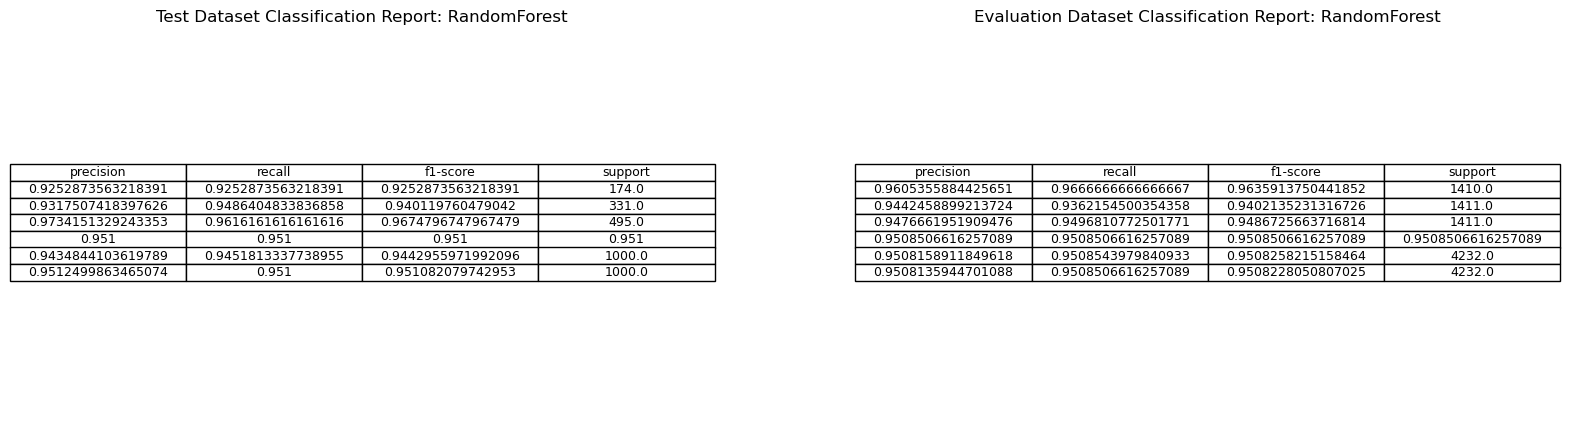

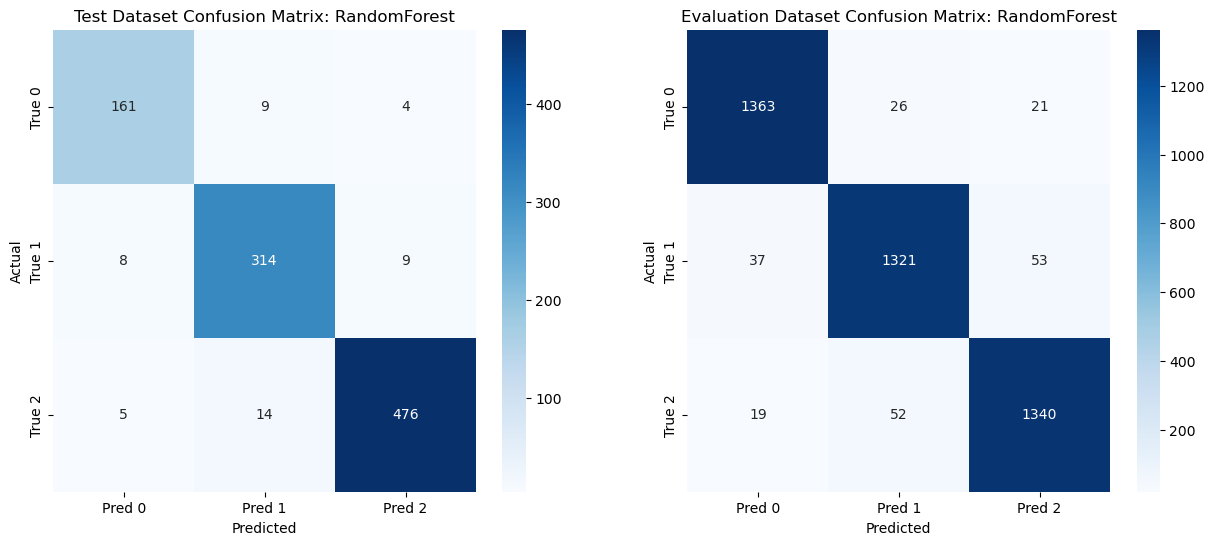

In [117]:

rf_test_predictions = models['RandomForest'].predict(X_test)
rf_test_report = classification_report(y_test, rf_test_predictions, output_dict=True)
rf_test_conf_matrix = confusion_matrix(y_test, rf_test_predictions)

# Evaluate RandomForest on the Evaluation Dataset
rf_eval_predictions = models['RandomForest'].predict(X_val)
rf_eval_report = classification_report(y_val, rf_eval_predictions, output_dict=True)
rf_eval_conf_matrix = confusion_matrix(y_val, rf_eval_predictions)

# Convert classification reports to DataFrames for better visualization
rf_test_report_df = pd.DataFrame(rf_test_report).transpose()
rf_eval_report_df = pd.DataFrame(rf_eval_report).transpose()

# Function to plot comparison table
def plot_comparison_table(df1, df2, title1, title2):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    axes[0].axis('tight')
    axes[0].axis('off')
    axes[0].table(cellText=df1.values, colLabels=df1.columns, cellLoc='center', loc='center')
    axes[0].set_title(title1)
    
    axes[1].axis('tight')
    axes[1].axis('off')
    axes[1].table(cellText=df2.values, colLabels=df2.columns, cellLoc='center', loc='center')
    axes[1].set_title(title2)
    
    plt.show()

# Function to plot confusion matrix comparison
def plot_confusion_matrix_comparison(cm1, cm2, title1, title2):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=['Pred 0', 'Pred 1', 'Pred 2'], yticklabels=['True 0', 'True 1', 'True 2'], ax=axes[0])
    axes[0].set_title(title1)
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')
    
    sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=['Pred 0', 'Pred 1', 'Pred 2'], yticklabels=['True 0', 'True 1', 'True 2'], ax=axes[1])
    axes[1].set_title(title2)
    axes[1].set_ylabel('Actual')
    axes[1].set_xlabel('Predicted')
    
    plt.show()

# Plot the classification report comparison
plot_comparison_table(rf_test_report_df, rf_eval_report_df, "Test Dataset Classification Report: RandomForest", "Evaluation Dataset Classification Report: RandomForest")

# Plot the confusion matrix comparison
plot_confusion_matrix_comparison(rf_test_conf_matrix, rf_eval_conf_matrix, "Test Dataset Confusion Matrix: RandomForest", "Evaluation Dataset Confusion Matrix: RandomForest")

In [118]:

# Step 1: Filter the Data to Include Only `SP` Features
sp_features = [col for col in df.columns if col.endswith('SP')]
X_sp = df[sp_features]
y_sp = df['Class']

# Step 2: Train a Decision Tree Classifier Using Only `SP` Features
decision_tree_sp = DecisionTreeClassifier(random_state=42)
decision_tree_sp.fit(X_sp, y_sp)

# Step 3: Visualize the Decision Tree
tree_rules = export_text(decision_tree_sp, feature_names=sp_features)
print(tree_rules)

|--- TFE Out flow SP <= 2249.11
|   |--- FFTE Steam pressure SP <= 119.98
|   |   |--- TFE Out flow SP <= 2100.70
|   |   |   |--- TFE Vacuum pressure SP <= -67.99
|   |   |   |   |--- FFTE Feed flow SP <= 9395.00
|   |   |   |   |   |--- TFE Production solids SP <= 64.25
|   |   |   |   |   |   |--- FFTE Steam pressure SP <= 103.50
|   |   |   |   |   |   |   |--- FFTE Steam pressure SP <= 94.00
|   |   |   |   |   |   |   |   |--- TFE Production solids SP <= 52.75
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- TFE Production solids SP >  52.75
|   |   |   |   |   |   |   |   |   |--- TFE Production solids SP <= 60.00
|   |   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |   |--- TFE Production solids SP >  60.00
|   |   |   |   |   |   |   |   |   |   |--- TFE Vacuum pressure SP <= -76.47
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |   |--- TFE Vacuum pressure SP 